In [81]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks, peak_prominences
import matplotlib.pyplot as plt

from multiprocessing import cpu_count
from multiprocessing import Pool

병렬 처리에 사용될 코드

In [82]:
num_cores = cpu_count()

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_cores)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [83]:
dg_df = pd.read_csv('./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/Demographics.csv')
dg_df.head(16)

,ID,Gender,HbA1c
0,13,MALE,5.7
1,1,FEMALE,5.5
2,3,FEMALE,5.9
3,4,FEMALE,6.4
4,5,FEMALE,5.7
5,2,MALE,5.6
6,6,FEMALE,5.8
7,7,FEMALE,5.3
8,8,FEMALE,5.6
9,10,FEMALE,6.0


In [84]:
df = pd.read_csv(r'./features.csv', sep='\t', encoding='utf-8')

In [85]:
df = df.dropna().drop(columns=['Unnamed: 0']).reset_index(drop=True)

In [86]:
df.isna().sum()

calories2hr       0
protein2hr        0
sugar2hr          0
carbs2hr          0
calories8hr       0
                 ..
ID                0
HbA1c             0
Biological Sex    0
CVSD              0
label             0
Length: 83, dtype: int64

In [87]:
df['Biological Sex'] = df['Biological Sex'].map({'FEMALE': 0, 'MALE': 1})

In [88]:
df['label'] = df['label'].map({'PersLow': 0, 'PersNorm': 1, 'PersHigh':2})

### 상관관계 Matrix Heat map

In [89]:
corrdf = df.drop(columns=['datetime']).corr()

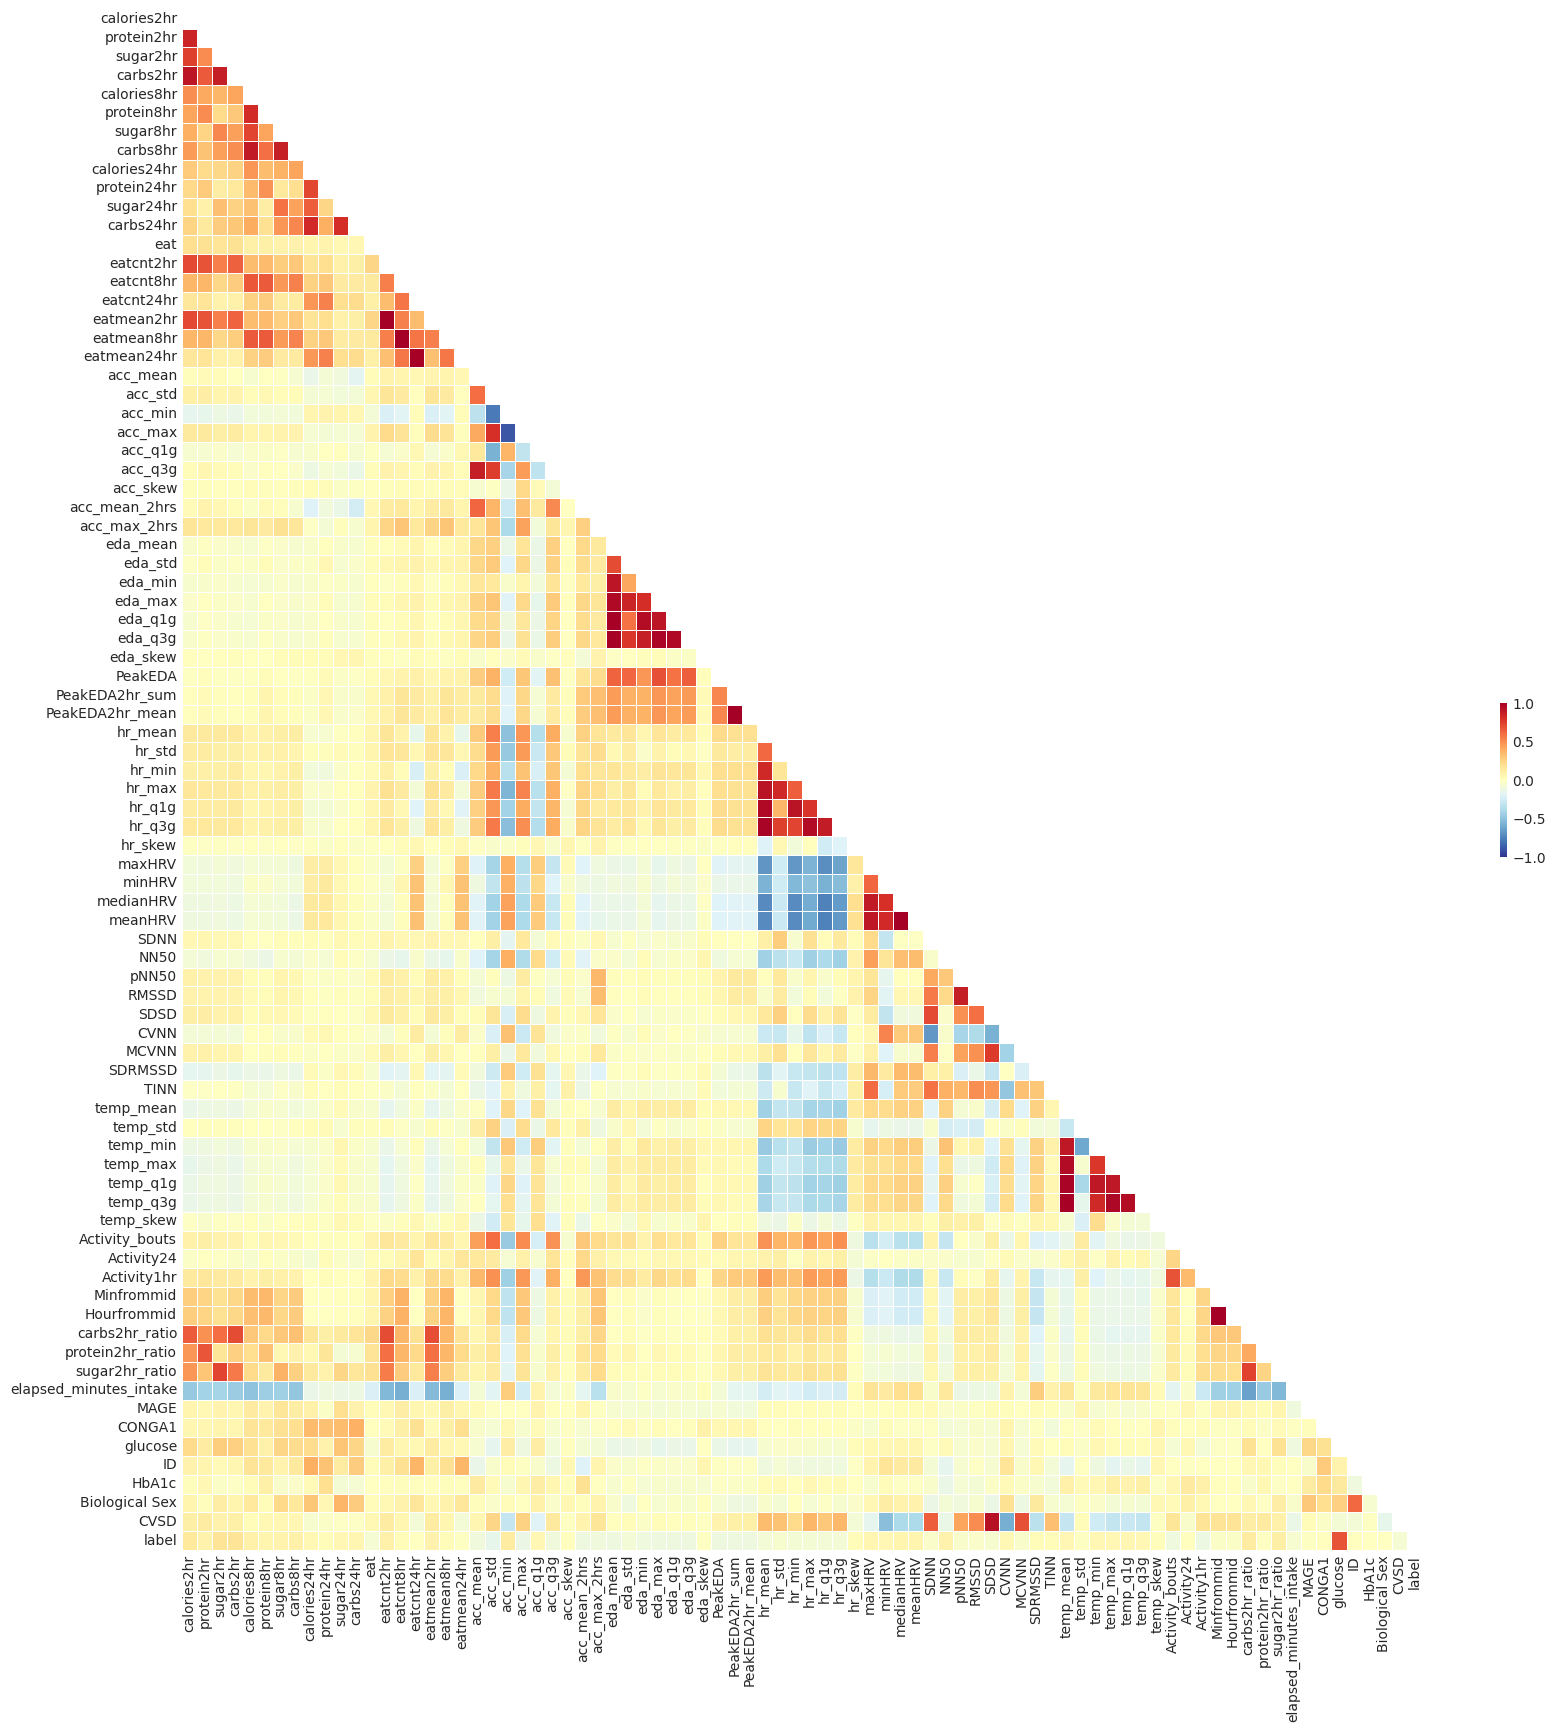

In [90]:
import seaborn as sns

# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(20,20) )

mask = np.zeros_like(corrdf)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(corrdf, 
            cmap = 'RdYlBu_r', 
            annot = False,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .1},# 컬러바 크기 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

### Leave-one-person-out cross validation Random forest regression 모델을 이용한 간질 포도당 예측에 대한 기여도 결정

In [91]:
def LOOCV_featureselection(data, ids, outcomevar, dropcols, idcolumn, numestimators=1000):
    """
        Intermediate function. Please use loocvRF function.
            
    """
    # Separate data for leave-one-person-out-cross-validation (LOOCV)
    LOOCV_O = ids 
    data[idcolumn] = data[idcolumn].apply(str)
    data_filtered = data[data[idcolumn] != LOOCV_O]
    data_cv = data[data[idcolumn] == LOOCV_O]
    
    print(len(data_filtered))
    print(len(data_cv))
    
    # Test data - the person left out of training
    data_test = data_cv.drop(columns=dropcols)
    X_test = data_test.drop(columns=[outcomevar])
    y_test = data_test[outcomevar] #This is the outcome variable
    
    # Train data - all other people in dataframe
    data_train = data_filtered.drop(columns=dropcols)
    X_train = data_train.drop(columns=[outcomevar])
    
    feature_list = list(X_train.columns)
    X_train= np.array(X_train)
    y_train = np.array(data_train[outcomevar]) #Outcome variable here

    
    from sklearn.ensemble import RandomForestRegressor
    # Instantiate model with numestimators decision trees
    rf = RandomForestRegressor(n_estimators = numestimators, random_state = 0)
    # Train the model on training data
    print('Now processing... LOOCV_featureselection')
    rf.fit(X_train, y_train)
    
    # Get importances:
    importances = list(rf.feature_importances_)# List of tuples with variable and importance
    important = pd.DataFrame()
    important['value'] = feature_list
    important['importances'] = importances
    
    return important

def RFLOOCV(data, ids, outcomevar, dropcols, idcolumn, numestimators=1000, fs=0.02):
    """
        Intermediate function. Please use loocvRF function.
            
    """
    # Get important features
    listimportances = LOOCV_featureselection(data, ids, outcomevar, dropcols, idcolumn, numestimators)
    filteredi = listimportances[listimportances['importances'] < fs]
    filteredi = filteredi['value']
    
    LOOCV_O = str(ids)
    data[idcolumn] = data[idcolumn].apply(str)
    data_filtered = data[data[idcolumn] != LOOCV_O]
    data_cv = data[data[idcolumn] == LOOCV_O]

    print(f'LOOCV_O : {LOOCV_O}')
   
    # Test data - the person left out of training
    data_test = data_cv.drop(columns=dropcols)
    data_test = data_test.drop(columns=filteredi) #cvf
    X_test = data_test.drop(columns=[outcomevar])
    y_test = data_test[outcomevar] #This is the outcome variable
    
    # Train data - all other people in dataframe
    data_train = data_filtered.drop(columns=dropcols)
    data_train = data_train.drop(columns=filteredi)
    X_train = data_train.drop(columns=[outcomevar])
    
    feature_list = list(X_train.columns)
    X_train= np.array(X_train)
    y_train = np.array(data_train[outcomevar]) #Outcome variable here

    
    from sklearn.ensemble import RandomForestRegressor# Instantiate model with 1000 decision trees
    rf = RandomForestRegressor(n_estimators = numestimators, random_state = 0)# Train the model on training data
    print('Now processing... RFLOOCV')
    rf.fit(X_train, y_train)
    
    # Use the forest's predict method on the test data
    predictions = rf.predict(X_test)
    errors = abs(predictions - y_test)
    
    # Root Mean Squared Error (RMSE)
    from sklearn import metrics
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, predictions))
    
    # Mean Average Percent Error (MAPE)
    MAPerror = np.mean(np.abs((y_test - predictions) / y_test)) * 100 
    
    # List of tuples with variable and importance
    importances = list(rf.feature_importances_)
    important = pd.DataFrame()
    important['value'] = feature_list
    important['importances'] = importances
    important['id'] = str(ids)
    
    return errors, RMSE, MAPerror, important

def loocvRF(data, idcolumn, outcomevar, dropcols=[], numestimators=1000, fs=0.02):
    """
        Main loocv RF function that calls other functions to do RF feature selection, training, and testing. 

        Args:
          data (pandas DataFrame): This is a dataframe containing each participant's features and outcome variables
          idcolumn (string): This is the column name of your column containing your participant number or ID (case sensitive)
          outcomevar (string): This is the column name of your outcome variable (case sensitive)
          dropcols (list): This is a list containing strings of each column you wish to drop in your dataframe. Default is empty list [].
          numestimators (integer): The number of trees you want built in your RF. Default=1000.
          fs (float): The cutoff importance for feature selection. Anything below this importance will be removed for the RF training.
          
        Returns:
            errors (list): This is a list with the absolute error between the predicted value and actual value for each fold.
            meanrmse (float): This is the mean root mean squared error (RMSE) over all of the folds
            stdrmse (float): This is the standard deviation of the root mean squared error (RMSE) over all of the folds
            meanrmse (float): This is the mean mean average percent error (MAPE) over all of the folds
            meanrmse (float): This is the standard deviation of the mean average percent error (MAPE) over all of the folds
            importances(pandas DataFrame): This is a pandas DataFrame with 3 columns: value (feature), importances (importance of the feature), and id (fold over which this feature importance was derived)
            
    """
    
    # Make list of all ID's in idcolumn
    IDlist = list(data[idcolumn].astype(str).unique())
    print(f'IDlist : {IDlist}')
    drop = [] #drop = [idcolumn]
    drop = drop + dropcols
    
    # Initialize empty lists and dataframe 
    errors = []
    rmse = []
    mape = []
    eval_metrics = pd.DataFrame(columns=['rmse', 'mape', 'id'])
    importances = pd.DataFrame(columns=['value', 'importances', 'id'])
    
    # Run LOOCV Random Forest! 
    for i in IDlist:
        er, rm, ma, imp= RFLOOCV(data, i, outcomevar, drop, idcolumn, numestimators, fs)
        errors.append(er)
        rmse.append(rm)
        mape.append(ma)
        eval = pd.DataFrame({'rmse': [rm], 'mape': [ma], 'id': [str(i)]})
        eval_metrics = pd.concat([eval_metrics, eval], ignore_index=True)
        importances = pd.concat([importances, imp], ignore_index=True)
        idt = str(i)
        print('...' + idt + ' processing complete.')

    # Compute mean and std RMSE, MAPE
    meanrmse = np.mean(rmse)
    stdrmse = np.std(rmse)
    meanmape = np.mean(mape)
    stdmape = np.std(mape)
    
    # Print RMSE, MAPE
    print('Mean RMSE:' + str(meanrmse))
    print('Std RMSE:' + str(stdrmse))
    print('Mean MAPE:' + str(meanmape))
    print('Std MAPE:' + str(stdmape))
    
    return eval_metrics, errors, meanrmse, stdrmse, meanmape, stdmape, importances

In [92]:
#errors, RMSE, RMSEstd, MAPE, MAPEstd, importances = loocvRF(data=df, idcolumn='ID', outcomevar='glucose', dropcols=['label', 'datetime'], numestimators=1000, fs=0.02)
eval_df, errors, RMSE, RMSEstd, MAPE, MAPEstd, importances = loocvRF(data=df, idcolumn='ID', outcomevar='glucose', dropcols=['label', 'datetime'], numestimators=100, fs=0.02)

IDlist : ['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0', '13.0', '14.0', '16.0']
28870
2310
Now processing... LOOCV_featureselection
LOOCV_O : 1.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/tmp/ipykernel_16756/3769959825.py:144: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  eval_metrics = pd.concat([eval_metrics, eval], ignore_index=True)
/tmp/ipykernel_16756/3769959825.py:145: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  importances = pd.concat([importances, imp], ignore_index=True)


...1.0 processing complete.
29182
1998
Now processing... LOOCV_featureselection
LOOCV_O : 2.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...2.0 processing complete.
29155
2025
Now processing... LOOCV_featureselection
LOOCV_O : 3.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...3.0 processing complete.
29213
1967
Now processing... LOOCV_featureselection
LOOCV_O : 4.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...4.0 processing complete.
28897
2283
Now processing... LOOCV_featureselection
LOOCV_O : 5.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...5.0 processing complete.
28622
2558
Now processing... LOOCV_featureselection
LOOCV_O : 6.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...6.0 processing complete.
29184
1996
Now processing... LOOCV_featureselection
LOOCV_O : 7.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...7.0 processing complete.
28905
2275
Now processing... LOOCV_featureselection
LOOCV_O : 8.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...8.0 processing complete.
29163
2017
Now processing... LOOCV_featureselection
LOOCV_O : 9.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...9.0 processing complete.
29189
1991
Now processing... LOOCV_featureselection
LOOCV_O : 10.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...10.0 processing complete.
28613
2567
Now processing... LOOCV_featureselection
LOOCV_O : 11.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...11.0 processing complete.
29264
1916
Now processing... LOOCV_featureselection
LOOCV_O : 12.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...12.0 processing complete.
29491
1689
Now processing... LOOCV_featureselection
LOOCV_O : 13.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...13.0 processing complete.
29319
1861
Now processing... LOOCV_featureselection
LOOCV_O : 14.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...14.0 processing complete.
29453
1727
Now processing... LOOCV_featureselection
LOOCV_O : 16.0
Now processing... RFLOOCV
...16.0 processing complete.
Mean RMSE:23.784230170053107
Std RMSE:4.624271015733137
Mean MAPE:15.927485380689005
Std MAPE:4.145608977380899


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [93]:
eval_df.head(20)

,rmse,mape,id
0,20.143516,15.754694,1.0
1,26.677089,15.529064,2.0
2,21.616411,14.423114,3.0
3,29.385961,23.079097,4.0
4,16.071817,13.369248,5.0
5,30.541534,15.393457,6.0
6,24.113498,24.883046,7.0
7,15.529502,10.607409,8.0
8,25.752340,13.973461,9.0
9,29.926185,18.133712,10.0


In [94]:
print(importances)

              value  importances    id
0          sugar2hr     0.037564   1.0
1          carbs2hr     0.073912   1.0
2       calories8hr     0.046453   1.0
3          sugar8hr     0.048929   1.0
4         sugar24hr     0.145917   1.0
..              ...          ...   ...
214            MAGE     0.055727  16.0
215          CONGA1     0.077221  16.0
216              ID     0.041517  16.0
217           HbA1c     0.055982  16.0
218  Biological Sex     0.087456  16.0

[219 rows x 3 columns]


In [95]:
imp_err = importances.groupby('value').std(numeric_only=True).rename(columns={'importances':'std'})#.sort_values(by='importances', ascending=False)

In [96]:
imp_err.head()

,std
value,
Activity24,0.006841
Biological Sex,0.041268
CONGA1,0.008706
HbA1c,0.012862
ID,0.012277


In [97]:
filteredimp = importances.groupby('value').mean(numeric_only=True).sort_values(by='importances', ascending=False)
filteredimp = pd.merge(filteredimp, imp_err, on='value')
print(filteredimp)

                        importances       std
value                                        
sugar24hr                  0.116850  0.034048
Minfrommid                 0.099231  0.012215
CONGA1                     0.081978  0.008706
elapsed_minutes_intake     0.079289  0.003932
carbs2hr                   0.079095  0.011728
HbA1c                      0.074910  0.012862
Biological Sex             0.074524  0.041268
MAGE                       0.071232  0.008898
Activity24                 0.069607  0.006841
PeakEDA2hr_mean            0.058704  0.014222
acc_max_2hrs               0.055736  0.005432
sugar8hr                   0.055124  0.014346
acc_mean_2hrs              0.052979  0.005036
calories8hr                0.049074  0.002909
carbs24hr                  0.046305  0.006712
ID                         0.045021  0.012277
carbs8hr                   0.044610  0.008518
sugar2hr                   0.043944  0.010617
PeakEDA2hr_sum             0.043477  0.014156
protein24hr                0.04000

/tmp/ipykernel_16756/3888890867.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


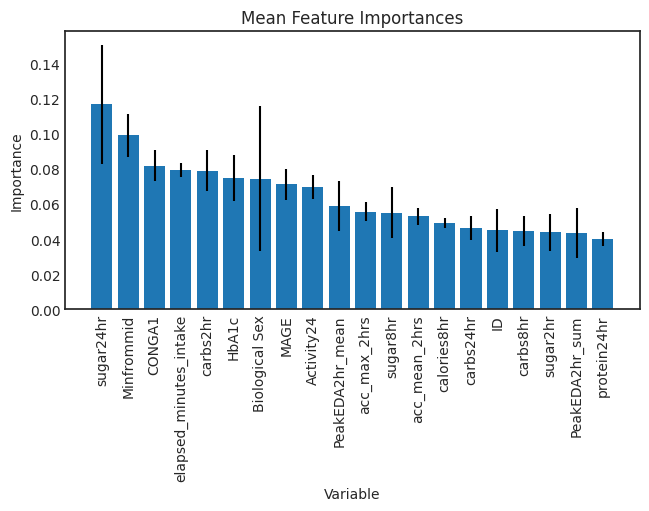

In [98]:
plt.style.use('seaborn-white')
x_values = list(range(len(filteredimp['importances'])))
# Make a bar chart
plt.bar(x_values, filteredimp['importances'], orientation = 'vertical', yerr=filteredimp['std'])# Tick labels for x axis
plt.xticks(x_values, filteredimp.index, rotation='vertical')# Axis labels and title
plt.tight_layout()
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title(('Mean Feature Importances'))
plt.show()

In [99]:
importances[importances['id'] == '1.0'].sort_values(by='importances', ascending=False).head(30)

,value,importances,id
4,sugar24hr,0.145917,1.0
11,Minfrommid,0.083994,1.0
12,elapsed_minutes_intake,0.074731,1.0
1,carbs2hr,0.073912,1.0
14,CONGA1,0.072294,1.0
15,HbA1c,0.068416,1.0
13,MAGE,0.067547,1.0
10,Activity24,0.066455,1.0
7,acc_max_2hrs,0.054949,1.0
3,sugar8hr,0.048929,1.0


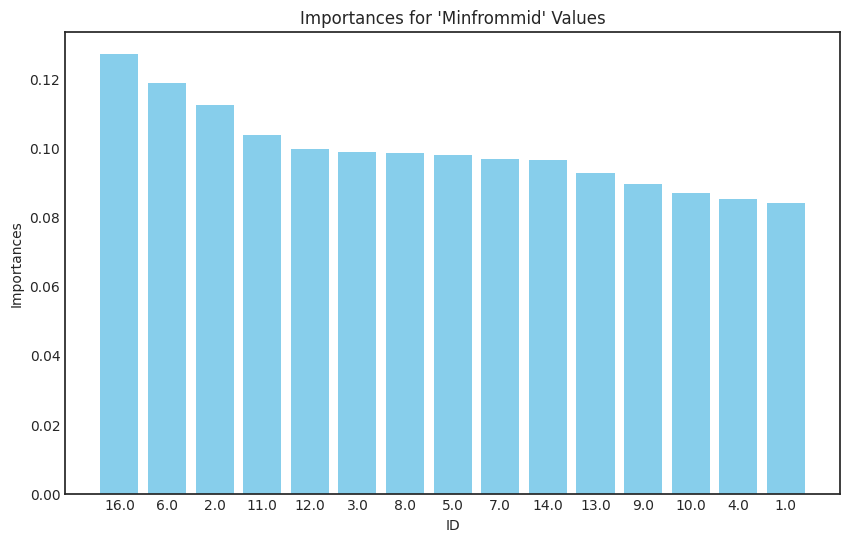

In [100]:
# 'value'가 'Minfrommid'인 항목 필터링
filtered_df = importances[importances['value'] == 'Minfrommid'].sort_values(by='importances', ascending=False)

# 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(filtered_df['id'], filtered_df['importances'], color='skyblue')
plt.xlabel('ID')
plt.ylabel('Importances')
plt.title("Importances for 'Minfrommid' Values")
plt.show()

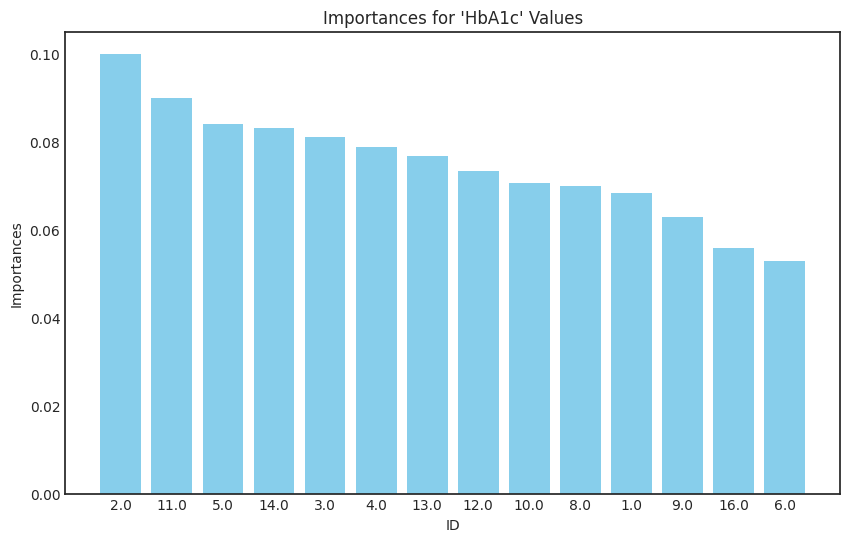

In [101]:
filtered_df = importances[importances['value'] == 'HbA1c'].sort_values(by='importances', ascending=False)

# 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(filtered_df['id'], filtered_df['importances'], color='skyblue')
plt.xlabel('ID')
plt.ylabel('Importances')
plt.title("Importances for 'HbA1c' Values")
plt.show()

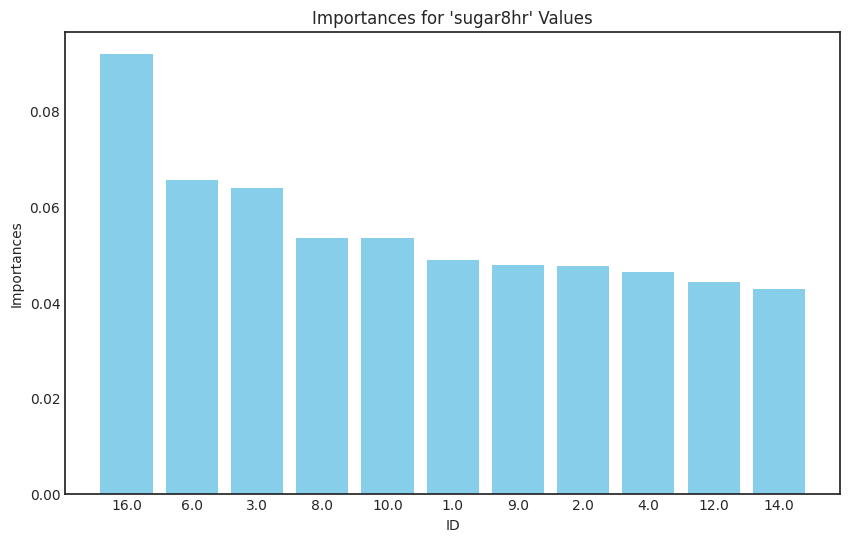

In [102]:
filtered_df = importances[importances['value'] == 'sugar8hr'].sort_values(by='importances', ascending=False)

# 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(filtered_df['id'], filtered_df['importances'], color='skyblue')
plt.xlabel('ID')
plt.ylabel('Importances')
plt.title("Importances for 'sugar8hr' Values")
plt.show()

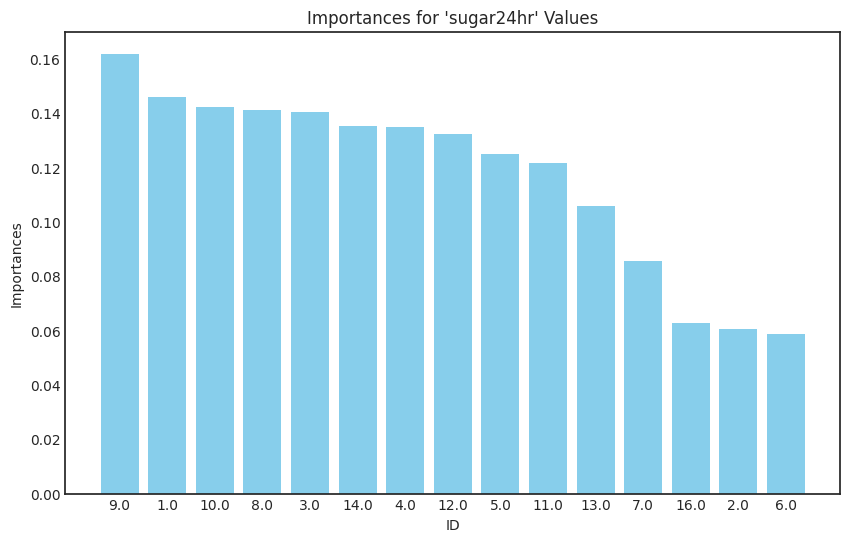

In [103]:
filtered_df = importances[importances['value'] == 'sugar24hr'].sort_values(by='importances', ascending=False)

# 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(filtered_df['id'], filtered_df['importances'], color='skyblue')
plt.xlabel('ID')
plt.ylabel('Importances')
plt.title("Importances for 'sugar24hr' Values")
plt.show()

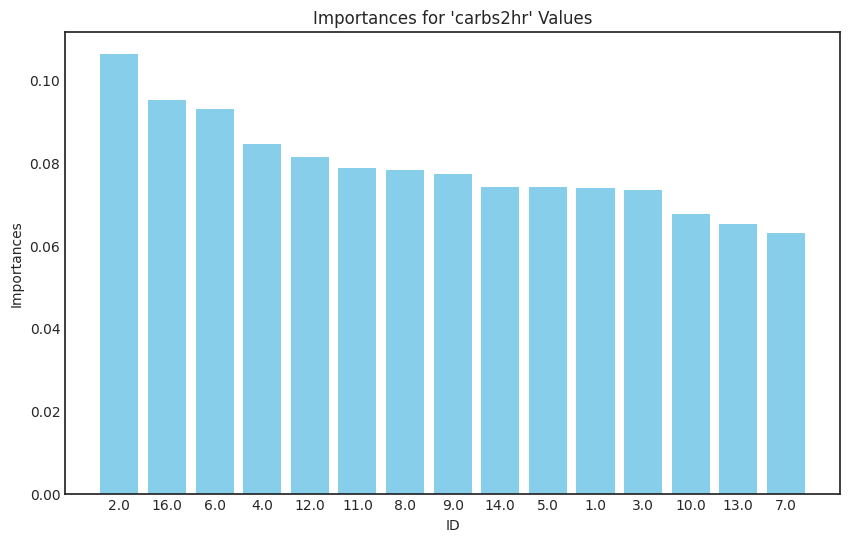

In [104]:
filtered_df = importances[importances['value'] == 'carbs2hr'].sort_values(by='importances', ascending=False)

# 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(filtered_df['id'], filtered_df['importances'], color='skyblue')
plt.xlabel('ID')
plt.ylabel('Importances')
plt.title("Importances for 'carbs2hr' Values")
plt.show()

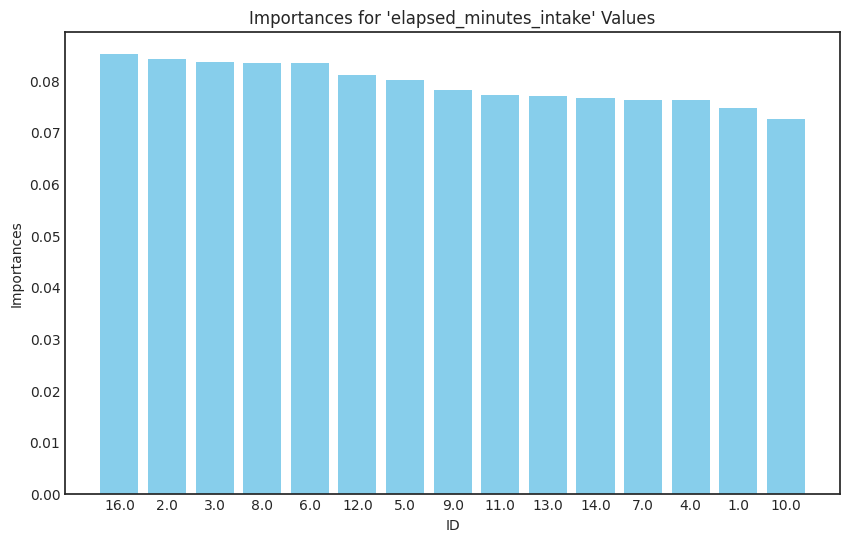

In [105]:
filtered_df = importances[importances['value'] == 'elapsed_minutes_intake'].sort_values(by='importances', ascending=False)

# 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(filtered_df['id'], filtered_df['importances'], color='skyblue')
plt.xlabel('ID')
plt.ylabel('Importances')
plt.title("Importances for 'elapsed_minutes_intake' Values")
plt.show()

In [106]:
importances[importances['id'] == '7.0'].sort_values(by='importances', ascending=False)

,value,importances,id
98,Minfrommid,0.096677,7.0
101,CONGA1,0.092668,7.0
92,sugar24hr,0.085702,7.0
99,elapsed_minutes_intake,0.076223,7.0
88,sugar2hr,0.073648,7.0
97,Activity24,0.070905,7.0
100,MAGE,0.070746,7.0
96,PeakEDA2hr_sum,0.065159,7.0
89,carbs2hr,0.063106,7.0
102,ID,0.058797,7.0
